In [1]:
#!pip install hyperopt datawig lightgbm pyod xgboost mxnet mlxtend category-encoders

### Download the Data

In [2]:
import os
import pandas as pd
import requests

# dataset is located in current directory
HOUSING_PATH = os.getcwd()

# function to load training dataset


def load_housing_data(filename="train.csv"):
    import numpy as np
    csv_path = os.path.join(HOUSING_PATH, filename)
    df = pd.read_csv(csv_path, dtype={'GarageYrBlt': np.float32, 'YearBuilt': np.float32, 'YrSold': np.float32, 'YearRemodAdd': np.float32,
                                      'LotFrontage': np.float32})

    return df

In [3]:
# Read files
X = load_housing_data('train_features.csv')
X_test = load_housing_data('test_features.csv')

# Save the 'Id' column
#train_ID = train['Id']
#test_ID = test['Id']

# Now drop the  'Id' colum since it's unnecessary for  the prediction process.
#train.drop("Id", axis=1, inplace=True)
#test.drop("Id", axis=1, inplace=True)

In [4]:
y=X['SalePrice'].values
X.drop('SalePrice', axis = 1, inplace = True)

Skewness: 0.153930


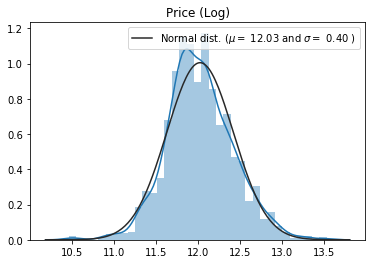

In [5]:
from matplotlib import pyplot as plt
%matplotlib inline 
from scipy.stats import norm, skew

import seaborn as sns
import seaborn as sns
# target feature transformed
sns.distplot(y , fit=norm);
(mu, sigma) = norm.fit(y)
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],loc='best')
plt.title('Price (Log)');
print("Skewness: %f" % pd.DataFrame(y).skew())

In [6]:
import numpy as np
np.isnan(y).any()

False

## Select and Train a Model 

In [7]:

from keras import backend as K
from keras.losses import *
import math

# root mean squared error (rmse) for regression (only for Keras tensors)
def rmse(y_true, y_pred):
    from keras import backend
    return backend.sqrt(backend.mean(backend.square(y_pred - y_true), axis=-1))

# coefficient of determination (R^2) for regression  (only for Keras tensors)
def r_square(y_true, y_pred):
    from keras import backend as K
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return abs( 1 - SS_res/(SS_tot + K.epsilon()) )


from keras.losses import logcosh

from keras import regularizers
from keras.layers.core import Dropout
from keras.models import Sequential
from keras.layers import Activation, Dense

def create_model(epochs=100, batch_size=32, dropout_rate=0.005, l=0.0001, lr=0.001, loss=mean_squared_error ):
    NN_model = Sequential()
    # The Input Layer :
    NN_model.add(Dense(6, kernel_initializer='normal',input_dim = X.shape[1], activation='relu'))
    # The Hidden Layers :
    #NN_model.add(Dense(1, kernel_initializer='normal',activation='relu',kernel_regularizer=regularizers.l2(l)))
    #NN_model.add(Dense(1, kernel_initializer='normal',activation='relu',kernel_regularizer=regularizers.l2(l)))
    #NN_model.add(Dropout(rate =dropout_rate))
    #NN_model.add(Dense(16, kernel_initializer='normal',activation='relu',kernel_regularizer=regularizers.l2(l)))
    NN_model.add(Dense(4, kernel_initializer='normal',activation='relu',kernel_regularizer=regularizers.l2(l)))
    # The Output Layer :
    NN_model.add(Dense(1, kernel_initializer='normal',activation='linear'))

    from keras import optimizers
    adam = optimizers.Adam(lr=lr)
    
    # Compile the network :
    NN_model.compile(loss=loss, optimizer=adam, metrics=['mse'])

    #NN_model.summary()

    return NN_model

NN_model = create_model()
NN_model.summary()

from keras.wrappers.scikit_learn import KerasRegressor
model = KerasRegressor(build_fn=create_model)



Using plaidml.keras.backend backend.
INFO:plaidml:Opening device "metal_amd_radeon_pro_wx_9100.0"


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 6)                 1422      
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 28        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 5         
Total params: 1,455
Trainable params: 1,455
Non-trainable params: 0
_________________________________________________________________


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

from joblib import Parallel, delayed, parallel_backend

with parallel_backend('threading'):
    param_grid = [
        # try 12 (3×4) combinations of hyperparameters
        #{'n_estimators': [30, 180, 220], 'max_features': [16, 32, 64, 128]},
        # then try 6 (2×3) combinations with bootstrap set as False
        {'epochs': [100, 50, 200], 'batch_size': [64, 32, 128], 'dropout_rate': [0.005, 0.01], 'l': [0.01, 0.0001, 0.05], 'lr': [0.001, 0.01, 0.003], 
        'loss': [hinge, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error]},
        ]

    #forest_reg = RandomForestRegressor(random_state=42)
    # train across 5 folds, that's a total of (12+6)*5=90 rounds of training 
    grid_search = GridSearchCV(model, param_grid, cv=3,
                                   scoring='neg_root_mean_squared_error', return_train_score=True, n_jobs = 8)

    grid_search.fit(X, y)



In [ ]:
grid_search.best_params_ 

In [ ]:

housing_predictions = np.expm1((grid_search.best_estimator_.predict(X_test)))
submission = pd.DataFrame(data=housing_predictions, index=housing_test.index , columns = ["SalePrice"])
submission.to_csv("sixteenth.csv")